In [1]:
# importing libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import metrics
import gc
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score, make_scorer,log_loss
from sklearn.model_selection import KFold


In [2]:
# Reading ratings file
ratings = pd.read_csv('Dataset/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id','movie_id','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('Dataset/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id','title','genres'])

In [4]:
df_movies = movies 
df_ratings = ratings

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [6]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_ratings.head(10)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [8]:
df_movies.isnull().values.any()

False

In [9]:
df_ratings.isnull().values.any()

False

In [16]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='b')

KeyError: '(no genres listed)'

<Figure size 1440x504 with 0 Axes>

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


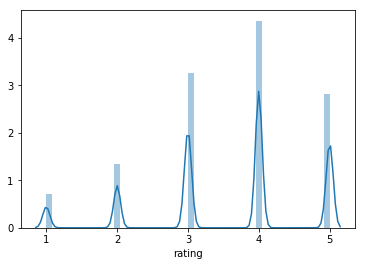

In [11]:
sns.distplot(df_ratings["rating"]);

In [15]:
df_ratings["No.RatingsPerUser"] = df_ratings.groupby('user_id')['user_id'].transform('count')


In [13]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm import LightFM

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [20]:
#fetch data and format
data = fetch_movielens(min_rating = 0.5)

#print training and testing data
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [21]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [22]:
#create model
model = LightFM(loss='warp')
#train model
model.fit(data['train'], epochs = 30, num_threads=2)

In [23]:
def sample_recommendation(model, data, user_ids):

    #number of users and movies in training data
    n_users, n_items = data['train'].shape

    #generate recommendations for each user input
    for user_id in user_ids: 

        #movies they always like
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        #movies the model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))
        #rank in order of most liked to least
        top_items = data['item_labels'][np.argsort(-scores)]

        #print results
        print("User %s" % user_id)
        print("         Known positives:")

        for x in known_positives[:3]:
            print("          %s" % x)
        
        print("         Recommend:")

        for x in top_items[:3]:
            print("         %s" % x)

In [25]:
sample_recommendation(model, data, [10, 30, 25, 34, 450])

User 10
         Known positives:
          Babe (1995)
          Dead Man Walking (1995)
          Seven (Se7en) (1995)
         Recommend:
         Raiders of the Lost Ark (1981)
         Star Wars (1977)
         Empire Strikes Back, The (1980)
User 30
         Known positives:
          Crumb (1994)
          Fugitive, The (1993)
          Lone Star (1996)
         Recommend:
         English Patient, The (1996)
         Full Monty, The (1997)
         L.A. Confidential (1997)
User 25
         Known positives:
          Toy Story (1995)
          Twelve Monkeys (1995)
          Dead Man Walking (1995)
         Recommend:
         Fargo (1996)
         Independence Day (ID4) (1996)
         Scream (1996)
User 34
         Known positives:
          Contact (1997)
          Mimic (1997)
          Kull the Conqueror (1997)
         Recommend:
         Dante's Peak (1997)
         Saint, The (1997)
         Scream (1996)
User 450
         Known positives:
          Kolya (1996)
        

In [28]:
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
auc_train = auc_score(model, data['train']).mean()
auc_test = auc_score(model, data['test']).mean()

In [29]:
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

Train AUC Score: 0.9468595385551453
Test AUC Score: 0.9083220958709717
